In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
# import functions from src folder
import data_generation as dg
import gradient_descent as gd
import regression_cost_funcs as rcf
import regression_tools as rt

In [5]:
sb.set_theme()

In this analysis we will evaluate model with MSE after a Gradient descent several times, we therefor consider it clever to employ a function which with given parameters and data gives us the MSE directly:

In [9]:
def find_MSE(X_train, X_test, z_train, z_test, w_init,
              model, learning_rate, epochs=1000, mode="normal",
                 momentum=0, batch_size=None, store_extra=False):
    
    """Returns the MSE for theese spesifications, works for ridge and lambda regression"""
    
    descent = gd.GradientDescent(mode=mode, momentum_param=momentum, batch_size=batch_size, store_extra=store_extra)
    w = descent.train(X_train, w_init, z_train, model, learning_rate=learning_rate, n_epochs = epochs)
    
    if store_extra: # To use when we want a plot over epochs
        MSE_arr = rt.MSE_vec(z_test, (X_test@descent.weights.T).T)
        return MSE_arr
    
    else:  
        MSE = rt.MSE(z_test, X_test@w.flatten())
        return MSE

# First part of GD analysis: Konstant $\eta_0$, aka mode="normal"

On our way towards SGD with mini-batches and momentum


1. Scaling:

    * In project 1 we used StandarScaler()
    
    * Find analytical solutions for the scaled and unscaled.
    
    * Check convergence a). for the scaled and b). unscaled.
    


2. Learning-rate analysis:
    
    * Plot MSE after n epochs as a function of $\eta$ for different $\lambda$
    
    * Find maximum learningrate before divergence for plain GD for different lambda
    
    
3.  SGD - Batch-size analysis:
    
    * A comparison of GD and SGD, plot over epochs
    
    * A plots for SGD, batch size = 1 for our model and sklearn's SGDregressor
    
    * MSE over Epochs for different batch sizes
    
    * MSE over Epochs now larger learningrate
    
    
4. Momentum analysis:

    * MSE over momentum for a few different learning rates 
    
    * MSE over Epochs for a few different momentum (set learing rate)  
    

5. Grid search: (random/limited area)
    
    * Grid search for lambda and learningrate
    
    * Plot with seaborn
    
$\Rightarrow $ our SGD-model with momentum.

# 1. Scaling:

should we or should we not scale the data, and how.

This scaling is in reason with the scaling in project_1:

### Generate data from franke function in line with project 1

In [262]:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)

# Scaling:
X_train_s = np.ones((len(X_train), len(X_train[0])))
X_test_s = np.ones((len(X_test), len(X_test[0])))
for i in range(20):
    X_train_s[:,i+1] = ( X_train[:,i+1] - np.mean(X_train[:,i+1]) ) / np.std(X_train[:,i+1])
for i in range(20):
    X_test_s[:,i+1] = ( X_test[:,i+1] - np.mean(X_train[:,i+1]) ) / np.std(X_train[:,i+1])
z_train_s = (z_train - np.mean(z_train))/np.std(z_train)
z_test_s = (z_test - np.mean(z_train))/np.std(z_train)

#alternativ and equivalent:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
z_train_s = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test_s = scaler.transform(z_test.reshape(-1,1)).flatten()


w = rt.ols_regression(X_train, z_train)
MSE_not_scaled = rt.MSE(z_test, X_test@w)

w_s = rt.ols_regression(X_train_s, z_train_s)
MSE_analytical_ols = rt.MSE(z_test_s, X_test_s@w_s)

print("Analytical MSE solutions:")
print("Not scaled:", MSE_not_scaled.round(4))
print("scaled:", MSE_analytical_ols.round(4))

print("MSE with zeros as weights:")
print("not scaled:", rt.MSE(z_test, X_test@ np.zeros(len(w_s))))
print("Scaled:", rt.MSE(z_test_s, X_test_s@ np.zeros(len(w_s))))

Analytical MSE solutions:
Not scaled: 0.0117
scaled: 0.1265
MSE with zeros as weights:
not scaled: 0.2898159061794116
Scaled: 1.1476724557284947


MSE over 1 in the case of the scaled data can be explained by the std of z_test scaled, which by randomness slighly differs from z_test_s. For diffrent seed this might of cource change.

In [93]:
print(np.std(z_train_s))
print(np.std(z_test_s))

1.0
1.0590396593426805


From this we set two bounderies for ols regression($\lambda=0$):
1. The minimum MSE we could expect - analytical solution, and call this MIN_MSE
2. The least we should expect from a model - MSE where weights is 0, and call this MAX_MSE

In [154]:
MIN_MSE = MSE_analytical_ols
MAX_MSE = rt.MSE(z_test_s, X_test_s@np.zeros(len(w_s)))
print(MIN_MSE, MAX_MSE)

0.1265452987470834 1.1476724557284947


We expecct MSE whithin this range, MSE over MAX_MSE is a sign of divergence, and a to high learningrate.

### Check convergence for descent on both scaled and unscaled data

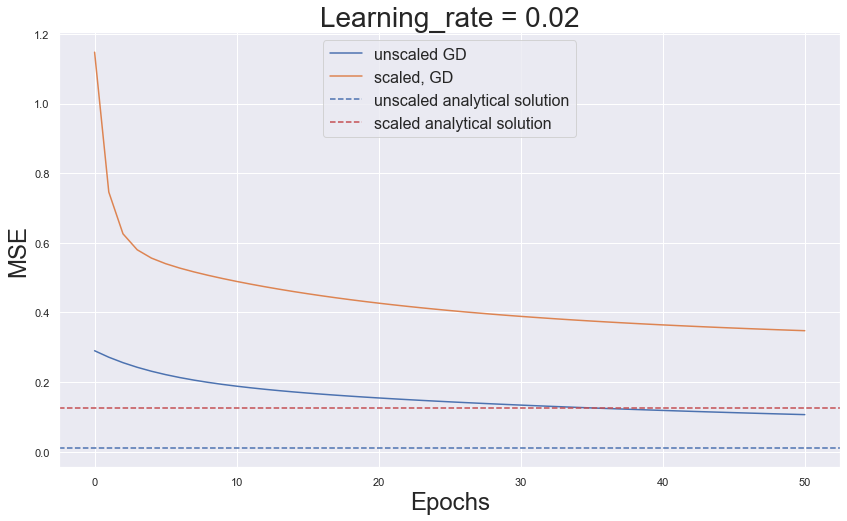

In [143]:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
z_train_s = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test_s = scaler.transform(z_test.reshape(-1,1)).flatten()

learning_rate = 0.02
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs_stop = 50
MSE = np.zeros(epochs_stop+1)
MSE_scaled = np.zeros(epochs_stop+1)
MSE = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")
MSE_scaled = find_MSE(X_train_s, X_test_s, z_train_s, z_test_s, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")

MSE_analytic = rt.MSE(z_test, X_test@rt.ols_regression(X_train, z_train))
MSE_scaled_analytic =rt.MSE(z_test_s, X_test_s@rt.ols_regression(X_train_s, z_train_s))

plt.figure(figsize=(14,8))
plt.title(f"Learning_rate = {learning_rate}", fontsize=28)
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE, label="unscaled GD")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_scaled, label="scaled, GD")
plt.axhline(MSE_analytic, linestyle="--", label="unscaled analytical solution")
plt.axhline( MSE_scaled_analytic, linestyle="--", label="scaled analytical solution", color="r")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

Comment to plot above: Both seems to converge to the analytical solution. 

In the futher analysis we would assume a standar scaling of the data, in line with sklean's StandarScaler() function. Therefor we expecting small learning-rates, estimated below $0.1$.

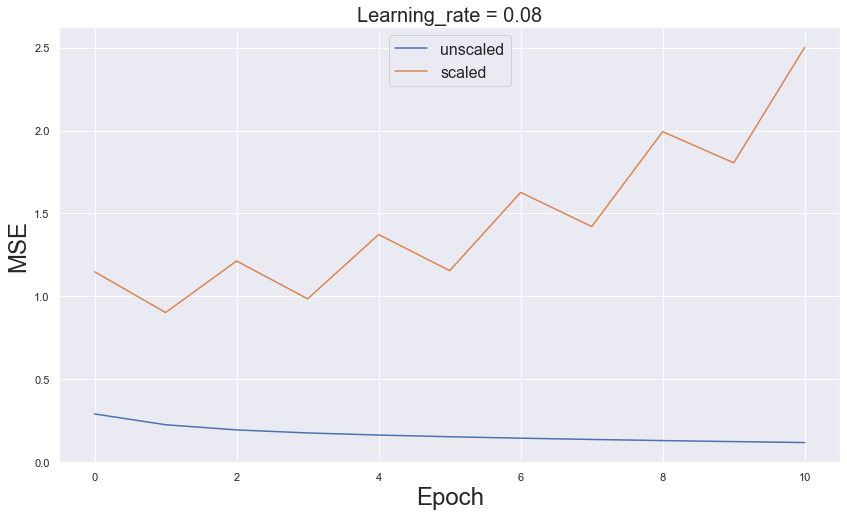

In [147]:
learning_rate = 0.08
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs_stop = 10
MSE = np.zeros(epochs_stop+1)
MSE_scaled = np.zeros(epochs_stop+1)

MSE = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")
MSE_scaled = find_MSE(X_train_s, X_test_s, z_train_s, z_test_s, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")


plt.figure(figsize=(14,8))
plt.title(f"Learning_rate = {learning_rate}", fontsize = 20)
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE, label="unscaled")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_scaled, label="scaled")
plt.xlabel("Epoch", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

Up to a upper limit of learning rate, we expect convergence both in the scaled and unscaled case. And above a lower limit we expect that both will diverge away from the minimum as the learning rate $\eta$ is to large. In between theese two limits of learningrates the scaled one will diverge and the unscaled converge as seen in the plot above We abandom the notation of _s for scaled, and one can assume all futher data to bee scaled after StandarScaler(). 

#  2. Learning rate analysis:

In [263]:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data and scale:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

# Gradient Descent anlysis:

Plot MSE as a function of learning-rate for OLS and Ridge (with a few different regularisation values)

In [156]:
w_init = np.zeros(len(X[0]))

In [157]:
# OLS and Ridge:
epochs = 1000
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0, 0.2, 50)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs, mode="normal")
        
        """ Implementation of settig MSE to nan if MSE[j] > limit"""
        if MSE_Ridge[i, j] > MAX_MSE + 0.5:
            MSE_Ridge[i, j] = np.NaN

/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_tools.py:20: RuntimeWarning: overflow encountered in square
  return np.sum((y_data - y_model) ** 2) / n
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: overflow encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y) + 2 * self.regularization * w
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: invalid value encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y) + 2 * self.regularization * w
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../gradient_descent.py:108: RuntimeWarning: invalid value encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: invalid value encountered in multiply
  return 2 / y.size * X.T @ (X

## 1000 n_epochs:

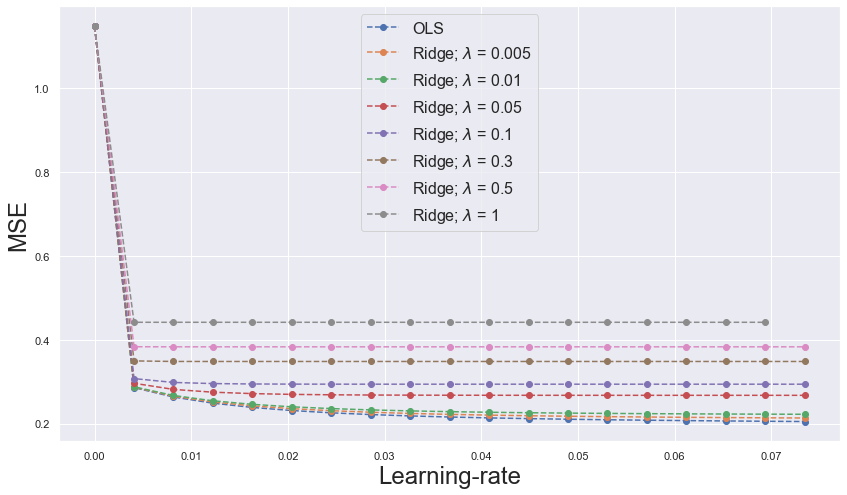

In [158]:
plt.figure(figsize=(14,8))
for i, lambdaer in enumerate(lambda_values):
    if lambdaer == 0:
        plt.plot(lr_range, MSE_Ridge[i], "--o", label=f"OLS")
    else:
        plt.plot(lr_range, MSE_Ridge[i], "--o", label=fr"Ridge; $\lambda$ = {lambdaer}")
plt.xlabel("Learning-rate", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

In [35]:
# Estimated divergence learning-rates for epochs : 1000
print(f"An estimate for the lagrgest learning rate we could choose before the GD diverges,")
print(f"for an given lambda is")
print("---------------------------------")

print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

An estimate for the lagrgest learning rate we could choose before the GD diverges,
for an given lambda is
---------------------------------
n_epochs = 1000 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.076       0.205
0.005        0.076       0.213
0.010        0.076       0.222
0.050        0.076       0.268
0.100        0.076       0.294
0.300        0.073       0.348
0.500        0.073       0.383
1.000        0.071       0.442


# For n_epochs 500 and 100 and 50

We now do a simmelar analysis to investigate how the number of epochs will change the result

In [36]:
print(f"An estimate for the lagrgest learning rate we could choose before the GD diverges,")
print(f"for an given lambda is")
print("---------------------------------")


# OLS and Ridge:
epochs = 500
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs)
        """ Implementation of settig MSE to nan if MSE[j] > limit"""
        if MSE_Ridge[i, j] > MAX_MSE + 0.5:
            MSE_Ridge[i, j] = np.NaN

print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

epochs = 100
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr,epochs=epochs)
        """ Implementation of settig MSE to nan if MSE[j] > limit"""
        if MSE_Ridge[i, j] > MAX_MSE + 0.5:
            MSE_Ridge[i, j] = np.NaN
            
print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

    
epochs = 50
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs)
        """ Implementation of settig MSE to nan if MSE[j] > limit"""
        if MSE_Ridge[i, j] > MAX_MSE + 0.5:
            MSE_Ridge[i, j] = np.NaN
            
print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

    
epochs = 10
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs)
        """ Implementation of settig MSE to nan if MSE[j] > limit"""
        if MSE_Ridge[i, j] > MAX_MSE + 0.5:
            MSE_Ridge[i, j] = np.NaN
            
print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

An estimate for the lagrgest learning rate we could choose before the GD diverges,
for an given lambda is
---------------------------------
n_epochs = 500 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.072       0.216
0.005        0.072       0.223
0.010        0.072       0.229
0.050        0.072       0.268
0.100        0.072       0.294
0.300        0.072       0.348
0.500        0.072       0.383
1.000        0.065       0.442
n_epochs = 100 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.072       0.268
0.005        0.072       0.270
0.010        0.072       0.271
0.050        0.072       0.284
0.100        0.072       0.299
0.300        0.072       0.348
0.500        0.072       0.383
1.000        0.065       0.442
n_epochs = 50 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.072       0.290
0.005        0.072       0.291
0.010        0.072       0.291
0.050      

As we can se there not really much to theese results. A higher lambda gives in this case poorer preformace, as we are not in the domain of overfitting with polydeg=5 (See project 1). Higher lambda also seems to give a lower maximum learningrate we could choose before divergence.

# 3. SGD -- Stochastic Gradient Descent

###  Batch size = 1
And now compare with SKlearn.
In Stochastic Gradient Descent we can choose a parameter called mini-batches.

For SKlearn we dont have this oppertuntity, we therrefor do one plot of MSE over learningrate for SGD with minibatches=1

We want to plot MSE for OLS and 

Choose lambda = 0.01

In [271]:
w_init = np.zeros(len(X[0]))
lambdaen = 0
model = rcf.RidgeCost(lambdaen)
epochs_range = [1000]

lr_range = np.linspace(0.00001, 0.005, 20)
MSE_Ridge = np.zeros((len(epochs_range), len(lr_range)))
MSE_SKlearn = np.zeros((len(epochs_range), len(lr_range)))
for i, epochs in enumerate(epochs_range):
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs, batch_size=1)
        """ Implementation of settig MSE to nan if MSE[j]>MSE[j=0] """
        if MSE_Ridge[i, j] > (MSE_Ridge[i, 0]+1):
            MSE_Ridge[i, j] = np.NaN
 
    for j, lr in enumerate(lr_range):
        sk_model = skl.SGDRegressor(loss="squared_loss", alpha=lambdaen, 
                                    max_iter=epochs, tol=None, learning_rate="constant", eta0=lr)
        sk_model.fit(X_train, z_train)
        z_pred_SK = sk_model.predict(X_test)
        MSE_SKlearn[i, j] = rt.MSE(z_test, z_pred_SK)
        if MSE_SKlearn[i, j] > (MSE_SKlearn[i, 0]+1):
            MSE_SKlearn[i, j] = np.NaN    

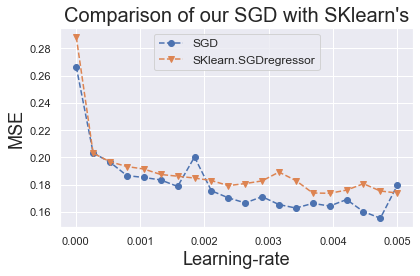

In [272]:
plt.figure()
for i, epochs in enumerate(epochs_range[:]):
    plt.plot(lr_range, MSE_Ridge[i], "--o", label=fr"SGD")
    plt.plot(lr_range, MSE_SKlearn[i], "--v", label=fr"SKlearn.SGDregressor")
plt.xlabel("Learning-rate", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title("Comparison of our SGD with SKlearn's", fontsize=20)
plt.legend(fontsize=12, loc="upper center")
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_SGD_ols")
plt.show()

## Plot over epochs

In [57]:
w_init = np.zeros(len(X[0]))
lambdaen = 0
model = rcf.RidgeCost(lambdaen)

epochs_stop = 1000
lr_range = [0.0001, 0.001, 0.005]
MSE_SG = np.zeros((len(lr_range), epochs_stop+1))
MSE_GD = np.zeros((len(lr_range), epochs_stop+1))
for i, lr in enumerate(lr_range):
    MSE_SG[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr,
                               epochs=epochs_stop, batch_size=1, store_extra=True)
    MSE_GD[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr,
                               epochs=epochs_stop, store_extra=True)

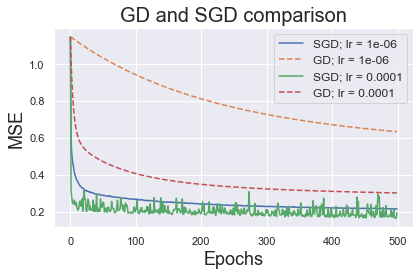

In [269]:
plt.figure()
#for i, lr in enumerate([lr_range[0],lr_range[2]]):
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1)[:500], MSE_SG[0][:500], label=fr"SGD; lr = {lr_range[0]}")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1)[:500], MSE_GD[0][:500], "--" ,label=fr"GD; lr = {lr_range[0]}")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1)[:500], MSE_SG[2][:500], label=fr"SGD; lr = {lr_range[2]}")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1)[:500], MSE_GD[2][:500], "--" ,label=fr"GD; lr = {lr_range[2]}")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.legend(fontsize=12, loc="upper right")
plt.title("GD and SGD comparison", fontsize=20)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/GD_SGD_comp")
plt.show()

Conclusions of the above: Whith SGD aka batch size = 1 we need even smaller learning rate. somewhere around 0.001, as higher learningrate gives more noise. 

## Mini batches

We now want a range of bach sizes. For computational renons we want batch sizes to be an power of 2.
A list with $[8, 32, 128, 256]$  Choose a learning-rate of 0.05, by investigating the plot above, where batch_size = 1.
We do this for OLSCost.

In [264]:
batch_sizes = np.array([16, 64, 256])
learning_rate = 0.02
model = rcf.OLSCost()
w_init = np.zeros(len(X[0]))
epochs_stop = 1000
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop+1)

MSE = np.zeros((len(batch_sizes), epochs_stop+1))
for i, b_size in enumerate(batch_sizes):
    MSE[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, batch_size=b_size, store_extra=True)

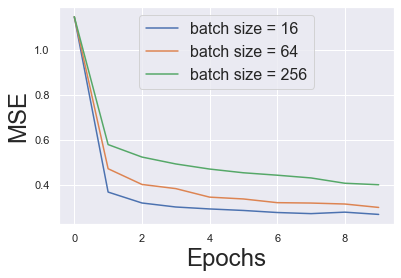

In [178]:
plt.figure()
for i, b in enumerate(batch_sizes):
    plt.plot(epochs_linspace[:10], MSE[i][:10], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

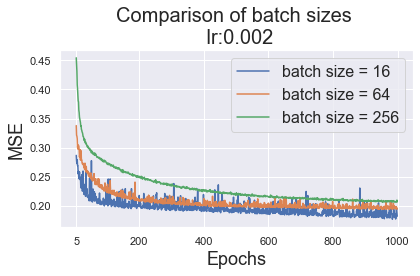

In [268]:
plt.figure()
for i, b in enumerate(batch_sizes):
    plt.plot(epochs_linspace[5:1000], MSE[i][5:1000], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.legend(fontsize=16, loc="upper right")
plt.xticks([5, 200, 400, 600, 800, 1000])
plt.title("Comparison of batch sizes \n lr:0.002", fontsize=20)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_batch_size")
plt.show()

## Sidequest what happens with 10_000 datapoints?

In [180]:
N = 10_000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()
MSE = np.zeros((len(batch_sizes), epochs_stop+1))

for i, b_size in enumerate(batch_sizes):
    MSE[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, batch_size=b_size, store_extra=True)
        

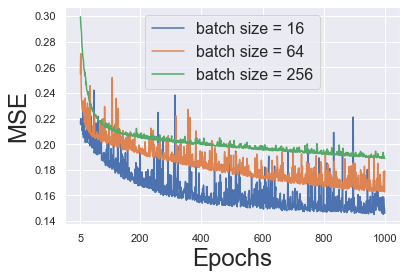

In [182]:
plt.figure()
for i, b in enumerate(batch_sizes):
    plt.plot(epochs_linspace[5:1000], MSE[i][5:1000], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.xticks([5, 200, 400, 600, 800, 1000])
plt.show()

# 4. Momentum Analysis

In [218]:
#Choose Data:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split and scale data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

In [221]:
batch_size = 128 #set a bach_size based on previos analysis
mode = "normal"
learning_rates = np.array([0.001, 0.005, 0.01, 0.05])
epochs = 1000
momentum_parms = np.linspace(0, 0.999, 100)
model = rcf.OLSCost()
w_init = np.zeros(len(X[0]))
MSE = np.zeros((len(learning_rates), len(momentum_parms) ))

for i, lr in enumerate(learning_rates):   
    for j, mom in enumerate(momentum_parms):
        MSE[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs, momentum=mom)
        """ Implementation of settig MSE to nan if MSE[j] > MSE[0] + ...
        if MSE[i, j] > MSE[i, 0]+ 0.5:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break
        """

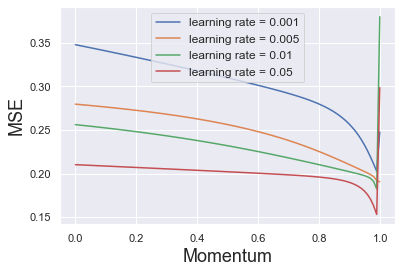

In [222]:
plt.figure()
for i, lr in enumerate(learning_rates):
    plt.plot(momentum_parms, MSE[i], label=fr"learning rate = {lr}")
plt.xlabel("Momentum", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.legend(fontsize=12, loc="upper center")
plt.show()

From this plot we can see that that for each learningrates, it converges to a smaller MSE as we increase the momentum. We se a spike when we approch one. This spike is discussed futher in the "side quest" under.

In [207]:
for i in range(len(learning_rates)):
    print("Lr:", learning_rates[i])
    print("min MSE:", np.min(MSE[i]))
    print("whith momentum:", momentum_parms[np.argmin(MSE[i])])

Lr: 0.001
min MSE: 0.20260979413862845
whith momentum: 0.988909090909091
Lr: 0.005
min MSE: 0.19044982513561906
whith momentum: 0.999
Lr: 0.01
min MSE: 0.18225336083210766
whith momentum: 0.988909090909091
Lr: 0.05
min MSE: 0.15300509537834409
whith momentum: 0.988909090909091


## Momentum over epoch:

In [216]:
batch_size = 128
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs_stop = 1000
n_epochs = epochs_stop +1
epochs_linspace = np.linspace(0, epochs_stop, n_epochs)

# We want two models of gradient decent; None, large and small mom
mom_arr = [0.4,0.7, 0.9, 0.99]
MSE_arr = np.zeros((len(mom_arr), n_epochs))

for i, mom in enumerate(mom_arr):
    MSE_arr[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                      learning_rate=0.05, epochs=epochs, momentum=mom, store_extra=True)

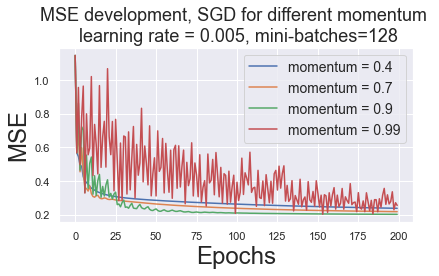

In [267]:
plt.figure()
for i, mom in enumerate(mom_arr):
    plt.plot(epochs_linspace[:200], MSE_arr[i][:200], label=fr"momentum = {mom}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=14)
plt.title("MSE development, SGD for different momentum \n learning rate = 0.005, mini-batches=128", fontsize=18)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_momentum_lr0005")
plt.show()

### Side Quest: What with momentum larger then 1?

In [223]:
batch_size = 128
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs = 1000

# We want two models of gradient decent; None, large and small mom
mom_arr = [1, 1.002]
MSE_arr = np.zeros((len(mom_arr), epochs+1))

for i, mom in enumerate(mom_arr):
    MSE_arr[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                      learning_rate=0.05, epochs=epochs, momentum=mom, store_extra=True)

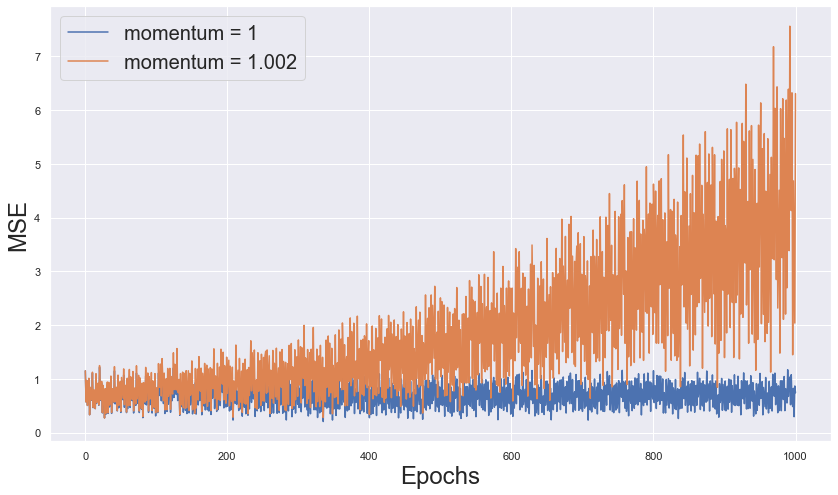

In [224]:
plt.figure(figsize=(14,8))
for i, mom in enumerate(mom_arr):
    plt.plot(np.linspace(0, epochs, epochs+1), MSE_arr[i], label=fr"momentum = {mom}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=20)
plt.show()

# 5. Gridsearch: Momentum and learningrate - lambda = 0

In [230]:
# Generate data for this whole analysis part:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data and scale:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

In [254]:
def grid_search_mom(X, z, lr_range, mom_range, mode="normal"):
    
    X_train, X_test, X_validation = X
    z_train, z_test, z_validation = z
    
    #set mini-bach size
    #set nr of epochs
    batch_size = 64
    epochs = 1000
    model = rcf.OLSCost()
    
    MSE_grid = np.zeros((len(lr_range), len(mom_range)))
    w_log = 0
    
    progress = 0
    for i, m in enumerate(mom_range):
        progress += 100/len(mom_range)
        for j, lr in enumerate(lr_range):
            #init weights
            w_init = np.zeros(len(X_train[0]))
            #Make model with i and j param
            descent = gd.GradientDescent(mode=mode, momentum_param=m,
                                       batch_size=batch_size)
            w = descent.train(X_train, w_init, z_train, model,
                              learning_rate=lr, n_epochs = epochs)
            #calculate MSE 
            mse = rt.MSE(z_test, X_test@w.flatten())
            MSE_grid[j, i] = mse
        print(f"progress = {progress:.2f}%", end="\r")
        
    return MSE_grid

In [255]:
import seaborn as sns
sns.set()


lr_range = np.logspace(-6, -1, 6)
mom_range = np.linspace(0.7, 1, 7)
modes = ["normal", "adam", "rmsprop", "adagrad"]
X = (X_train, X_test, 0)
z = (z_train, z_test, 0)

MSE_grid = grid_search_mom(X, z, lr_range, mom_range, mode="normal")

7


/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_tools.py:20: RuntimeWarning: overflow encountered in square
  return np.sum((y_data - y_model) ** 2) / n


/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:122: RuntimeWarning: overflow encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:122: RuntimeWarning: invalid value encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y)


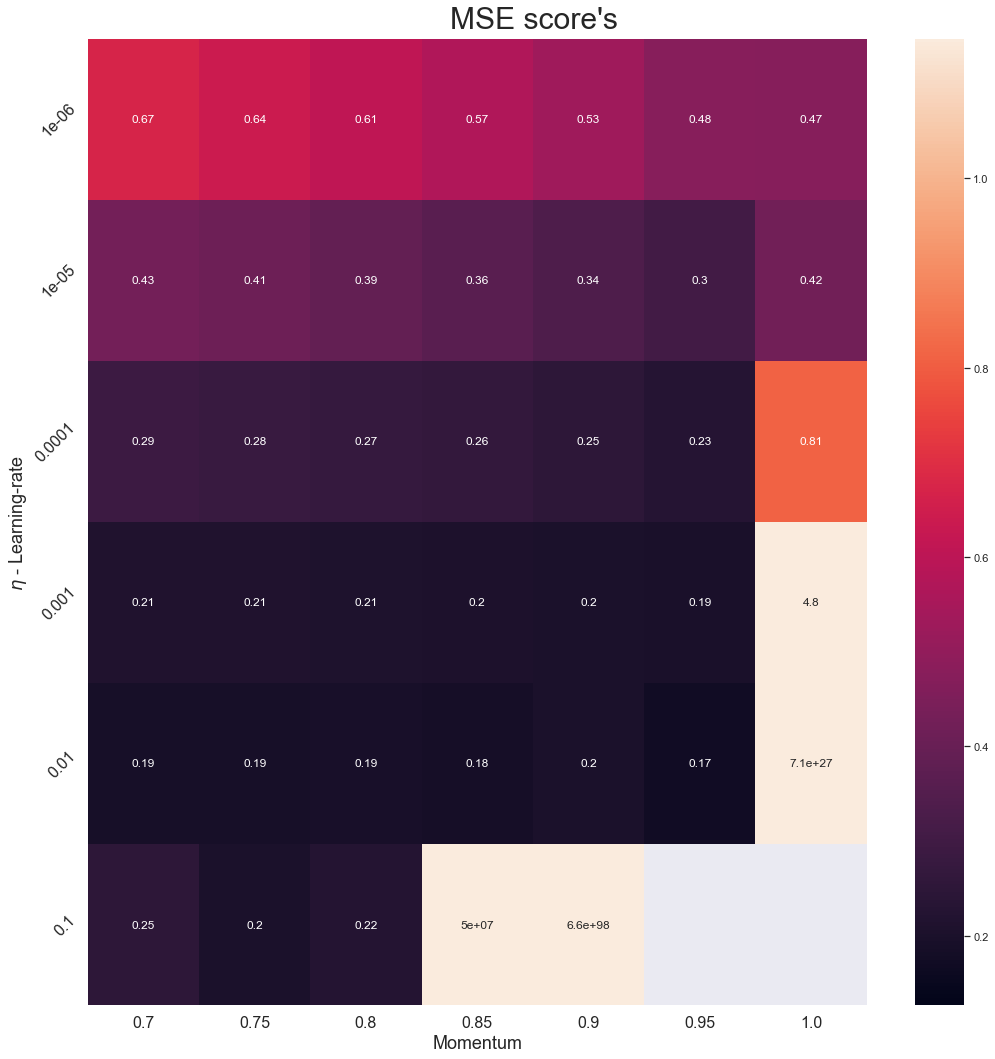

In [257]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
vmin = MSE_analytical_ols
vmax = rt.MSE(z_test, X_test@w_init)
sns.heatmap(MSE_grid, annot=True, ax=ax, vmin=vmin , vmax=vmax)
ax.set_yticklabels(lr_range, rotation=45)
ax.set_xticklabels(mom_range.round(2))
ax.set_ylabel("$\eta$ - Learning-rate", fontsize=18)
ax.set_xlabel("Momentum", fontsize=18)
ax.tick_params(labelsize=16)
plt.suptitle("MSE score's", fontsize=30)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/HM_plot_lr_lambda")
plt.show()

This analasys gives a estimate of an optimal model whith the following parameters:
Learning rate $= 0.05$
Batch size $= 128$
Momentum $= 0.99$
Theese where found only by looking at what we saw as reasonable parameters in our plots,
to do a more detatailed search for parameters one would do a grid search. Whith mode nomal.

# Different modes

Modes like adam, adagrad and rms-prop would adjust the learning rate. We would like to investigate how this affect out models preformence compered to mode "normal" with momentum where we don't adjust the learningrate.

There are some things more interesting than other:

1. Learning rate analysis:

    * For each mode plot MSE over Epochs for 5 different lr with OLS reg - might not be so interesting
    
    * Plot MSE over learningrates for each mode with OLS reg
    
    * Same as over but with some lambda values - aka 4 sub-plots  #TODO 
    
    
2. The SGD - Batch-size analysis:
    
    * Four plots for each mode batch size = 1 for a few different learningrates MSE over Epochs 
    
    * Four plots (for each mode) MSE over learning rate for 64, 128 and 256
    
    * MSE over epochs for batch_size 64, 128, 256 - Fixed learning rate - might differ
    
    
3. Momentum analysis:

    * MSE over momentum 4 plots (Equal Axis) for a few different learning rates 
    
    * MSE over Epochs 4 plots (Equal Axis) for a few different momentum set learing rates   
    

4. Grid search: (random/limited area)
    
    * Four plots, grid search for lambda and learningrate
    
    * Plot with seaborn

In [234]:
# Generate data for this whole analysis part:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data and scale:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

We should bring back the analytical solution we retain by the ols regression:

In [707]:
# Analytical solution:
weights = rt.ols_regression(X_train, z_train)
MSE_analytical_ols = rt.MSE(z_test, X_test@weights)
print("MSE from analytical solutions:")
print(MSE_analytical_ols.round(3))

MSE from analytical solutions:
0.127


This will be a benchmark for the futher analysis. 

# 1. Learning-rate analysis for the four mode's

## OLS, MSE over Epochs
We do this for the four mode's and for different learning rates

In [598]:
modes = ["normal", "adam", "rmsprop", "adagrad"]
n_features = len(X_train[0])
init_weights = np.zeros(n_features)
model = rcf.RidgeCost(0) #The same as rcf.OLSCost()

epochs_stop = 50_000
n_epochs = epochs_stop + 1
epochs_linspace = np.linspace(0, epochs_stop, n_epochs, dtype=int) #to use in plot
learning_rates = [0.001, 0.01, 0.04, 0.1]
n_lr = len(learning_rates)

MSE_normal = np.zeros((n_lr, n_epochs))
MSE_adam = np.zeros((n_lr, n_epochs))
MSE_rmsprop = np.zeros((n_lr, n_epochs))
MSE_adagrad = np.zeros((n_lr, n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                             mode=modes[j],learning_rate=lr, 
                             epochs=epochs_stop, store_extra=True)

/Users/halvortyseng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:138: RuntimeWarning: overflow encountered in square
  return np.mean((X @ w - y) ** 2) + self.regularization * np.sum(w ** 2)
/Users/halvortyseng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean((X @ w - y) ** 2) + self.regularization * np.sum(w ** 2)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:138: RuntimeWarning: overflow encountered in matmul
  return np.mean((X @ 

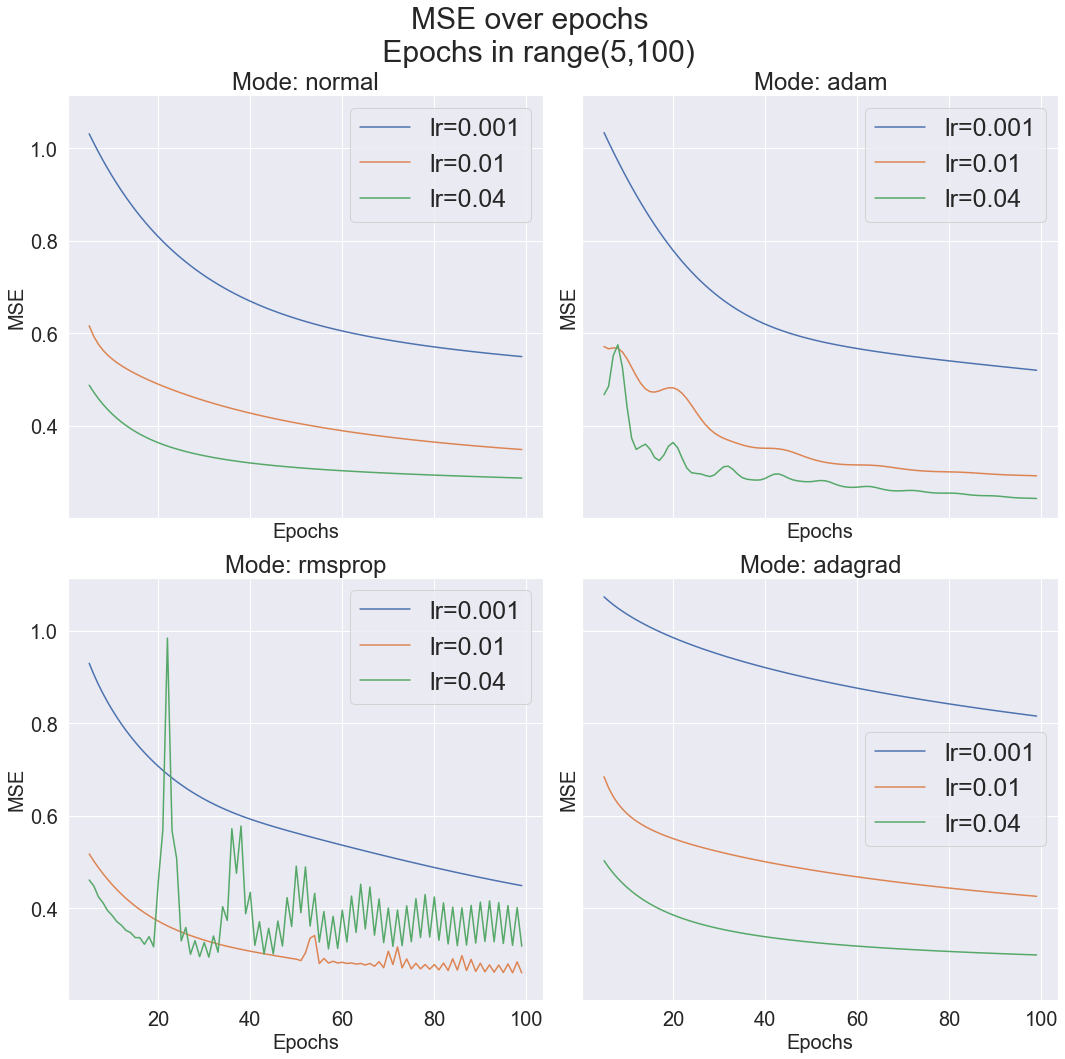

In [620]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

start = 5; stop = 100
fig.suptitle(f"MSE over epochs \n Epochs in range({start},{stop})", fontsize=30)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    ax.tick_params(labelsize=20)
    for j, lr in enumerate(learning_rates[:-1]):
        ax.plot(epochs_linspace[start:stop], MSE_modes[i][j][start:stop], label=f"lr={lr}")
    ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_epochs")

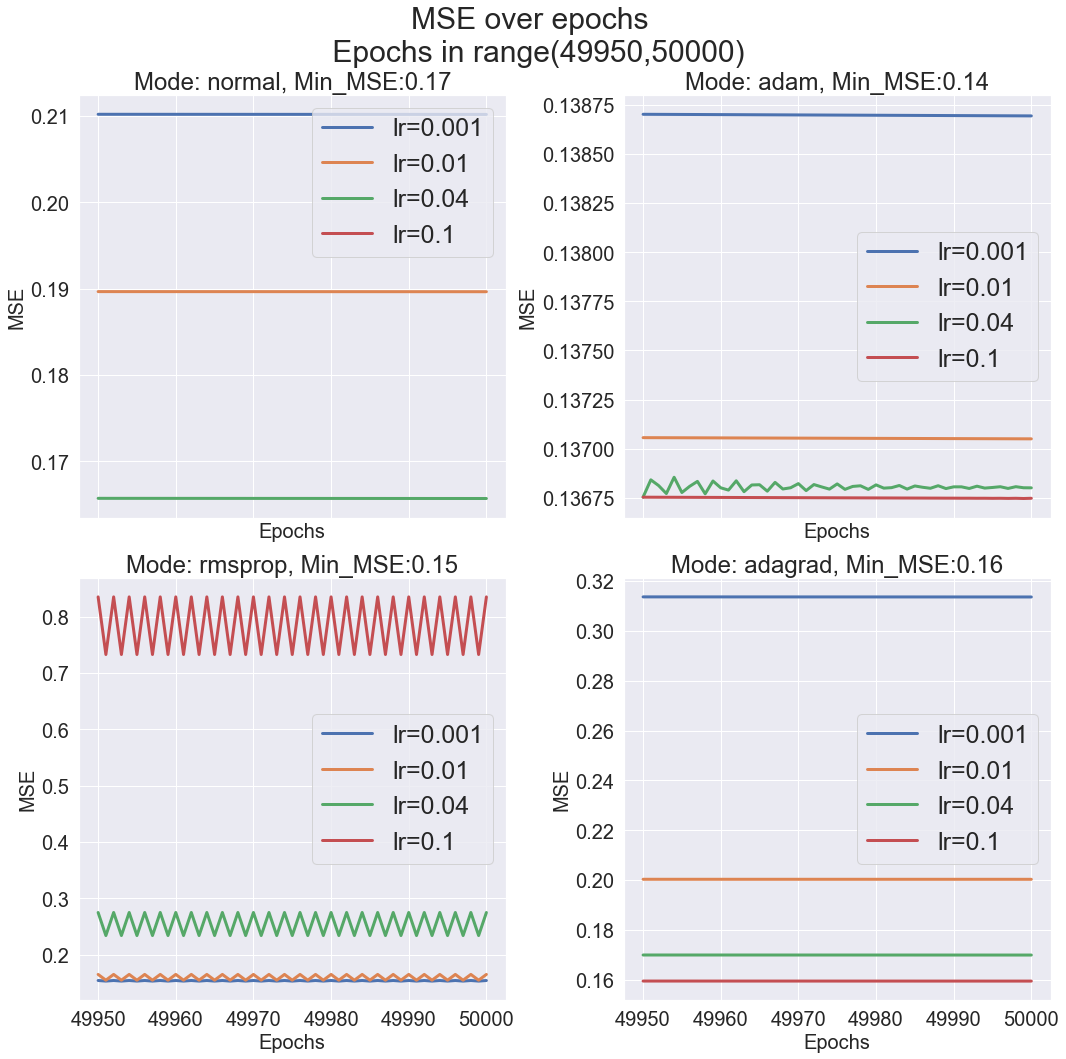

In [625]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)

start = 49950; stop = epochs_stop
fig.suptitle(f"MSE over epochs \n Epochs in range({start},{stop})", fontsize=30)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}, Min_MSE:{np.nanmin(MSE_modes[i]):.2f}", fontsize=24)
    ax.tick_params(labelsize=20)
    for j, lr in enumerate(learning_rates):
        ax.plot(epochs_linspace[49950:], MSE_modes[i][j][49950:], linewidth=3,label=f"lr={lr}")
    ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_epochs_largeepochs")

## MSE over learningrate
In this case we have to set a limit on the epochs, n_epochs = $...$. 

We implement so when the MSE diverges above a limit, the case is discarded, and the value is set to "NaN" so the plotting will work out.

In [372]:
epochs_stop = 1000
learning_rates = np.linspace(0.0001, 0.9)
n_lr = len(learning_rates)

MSE_normal = np.zeros(n_lr)
MSE_adam = np.zeros(n_lr)
MSE_rmsprop = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 2:
            MSE_mode[i] = np.NaN

/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_tools.py:20: RuntimeWarning: overflow encountered in square
  return np.sum((y_data - y_model) ** 2) / n
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: overflow encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y) + 2 * self.regularization * w
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: invalid value encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y) + 2 * self.regularization * w
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../gradient_descent.py:108: RuntimeWarning: invalid value encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: invalid value encountered in multiply
  return 2 / y.size * X.T @ (X

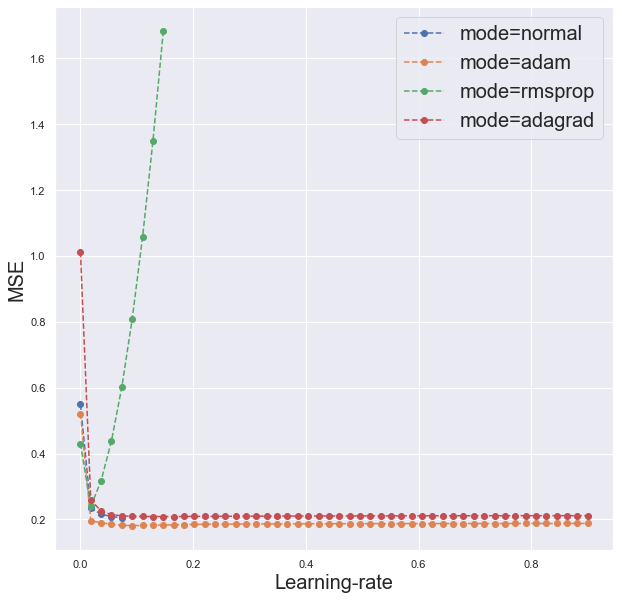

In [361]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axs.set_xlabel("Learning-rate", fontsize=20)
axs.set_ylabel("MSE", fontsize=20)
axs.set_title(f"", fontsize=24)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], "--o",label=f"mode={mode}")
axs.legend(fontsize=20)
plt.show()

This makes us consider to cases, one small intervall to analyse normal and rmsprop, and one longer to investigate adam and adagrad

In [654]:
epochs_stop = 1000
learning_rates = np.linspace(0.0001, 0.01)
n_lr = len(learning_rates)
modes = ["normal", "adam", "rmsprop", "adagrad"]

MSE_normal = np.zeros(n_lr)
MSE_adam = np.zeros(n_lr)
MSE_rmsprop = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 1.2:
            MSE_mode[i] = np.NaN

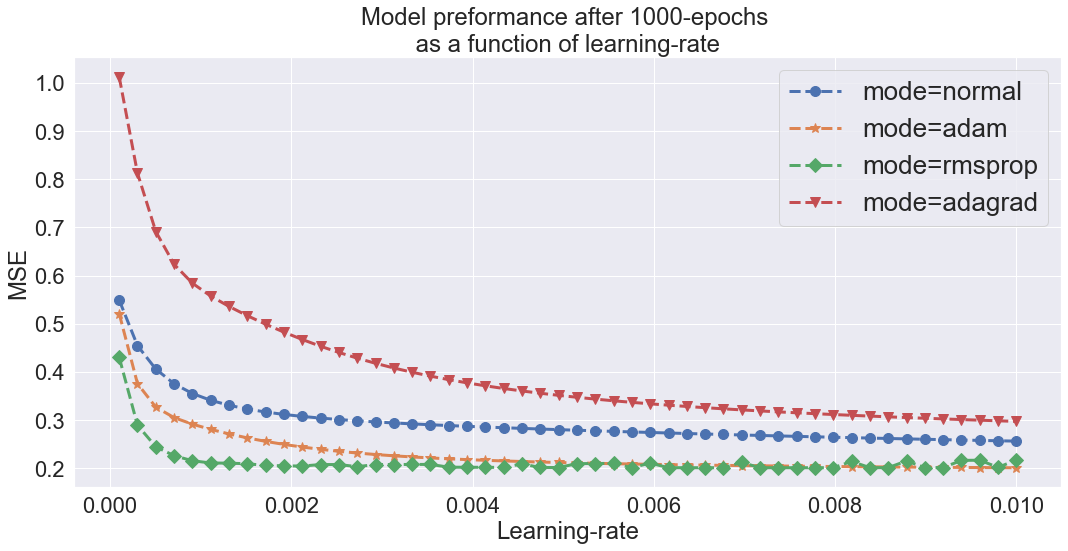

In [655]:
markers = ["o", "*", "D", "v"]
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)

fig.suptitle(f"")
axs.set_xlabel("Learning-rate", fontsize=24)
axs.set_ylabel("MSE", fontsize=24)
axs.set_title(f"Model preformance after 1000-epochs \n as a function of learning-rate ", fontsize=24)
axs.tick_params(labelsize=22)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], f"--{markers[j]}",lw=3, ms=10, label=f"mode={mode}")
axs.legend(fontsize=26)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_LR_lowlr")
plt.show()

In [134]:
epochs_stop = 1000
learning_rates = np.logspace(-4, 1)
n_lr = len(learning_rates)
modes = ["normal", "adam", "rmsprop", "adagrad"]
markers = ["o", "*", "D", "v"]

MSE_normal = np.zeros(n_lr)
MSE_adam = np.zeros(n_lr)
MSE_rmsprop = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 1.2:
            MSE_mode[i] = np.NaN
        

/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_tools.py:20: RuntimeWarning: overflow encountered in square
  return np.sum((y_data - y_model) ** 2) / n
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:122: RuntimeWarning: overflow encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:122: RuntimeWarning: invalid value encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../gradient_descent.py:108: RuntimeWarning: invalid value encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../gradient_descent.py:108: RuntimeWarning: overflow encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)


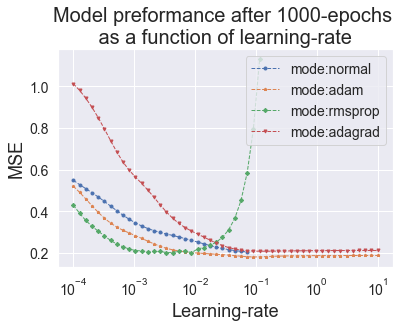

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)


axs.set_xlabel("Learning-rate", fontsize=18)
axs.set_ylabel("MSE", fontsize=18)
axs.set_title(f"Model preformance after 1000-epochs \n as a function of learning-rate ", fontsize=20)
axs.tick_params(labelsize=14)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j],f"--{markers[j]}", lw=1, ms=3, label=f"mode:{mode}")

axs.set_xscale('log')
axs.legend(fontsize=12, loc="center right")
plt.savefig("../plots/Gradient_descent/MSE_LR")
plt.show()

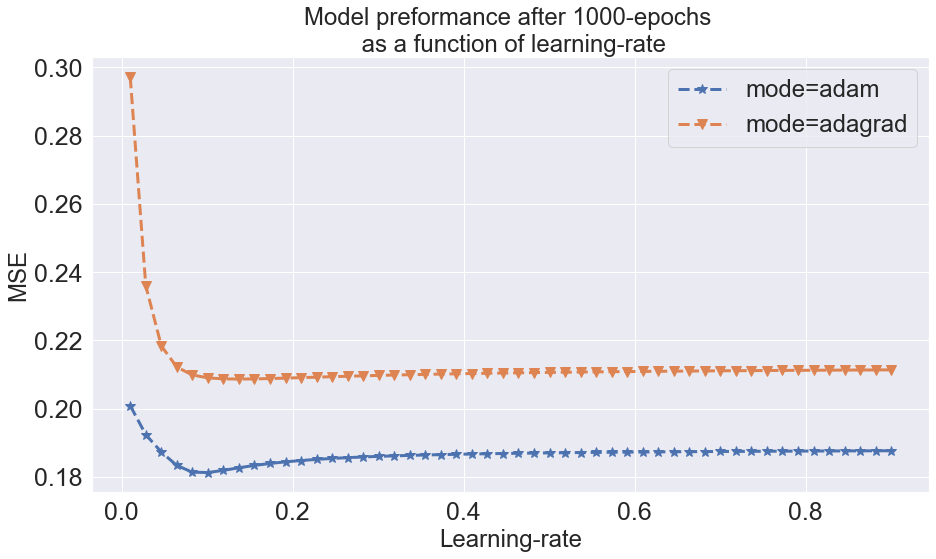

In [658]:
epochs_stop = 1000
learning_rates = np.linspace(0.01, 0.9)
n_lr = len(learning_rates)

modes = ["adam", "adagrad"]
markers = ["*", "v"]
MSE_adam = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_adam, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 1.2:
            MSE_mode[i] = np.NaN
            
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)

axs.set_xlabel("Learning-rate", fontsize=24)
axs.set_ylabel("MSE", fontsize=24)
axs.set_title(f"Model preformance after 1000-epochs \n as a function of learning-rate", fontsize=24)
axs.tick_params(labelsize=25)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], f"--{markers[j]}", lw=3, ms=10, label=f"mode={mode}")
axs.legend(fontsize=24)
plt.savefig("../plots/Gradient_descent/MSE_highLR")
plt.show()

One final plot og MSE for adam and adagrad over epochs for higher learingrates

In [394]:
epochs_stop = 60
n_epochs = epochs_stop + 1
epochs_linspace = np.linspace(0, epochs_stop, n_epochs, dtype=int) #to use in plot
learning_rates = [0.04, 0.09, 0.1]
n_lr = len(learning_rates)

MSE_adam = np.zeros((n_lr, n_epochs))
MSE_adagrad = np.zeros((n_lr, n_epochs))
MSE_modes = [MSE_adam,MSE_adagrad] #use when plotting

for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop, store_extra=True)

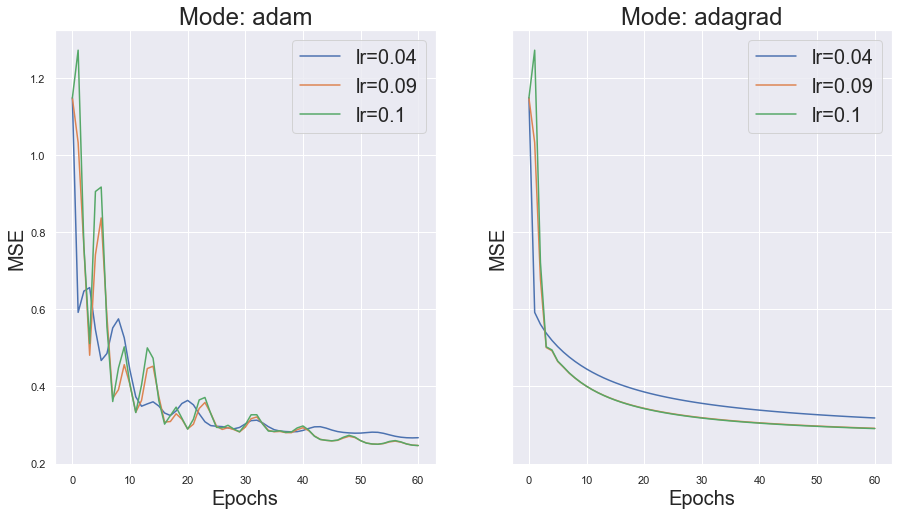

In [395]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    for j, lr in enumerate(learning_rates):
        ax.plot(epochs_linspace, MSE_modes[i][j], label=f"lr={lr}")
    ax.legend(fontsize=20)

# 2. The SGD - Batch-size analysis:

*  Four plots for each mode batch size = 1 for a few different learningrates MSE over Epochs 


In [665]:
batch_size = 1
epochs_stop = 200
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)
n_epochs = len(epochs_linspace)
learning_rates = [[0.0001, 0.001, 0.01], #lr for mode = normal
                  [0.0001, 0.001, 0.01], #mode = adam
                  [0.0001, 0.001, 0.01], #rmsprop
                  [0.0001, 0.001, 0.01, 0.1, 0.5]] #adagrad
n_lr = [len(x) for x in learning_rates]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_lr[0], n_epochs))
MSE_adam = np.zeros((n_lr[1], n_epochs))
MSE_rmsprop = np.zeros((n_lr[2], n_epochs))
MSE_adagrad = np.zeros((n_lr[3], n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates[j]):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, batch_size=batch_size,
                                 epochs=epochs_stop, store_extra=True)

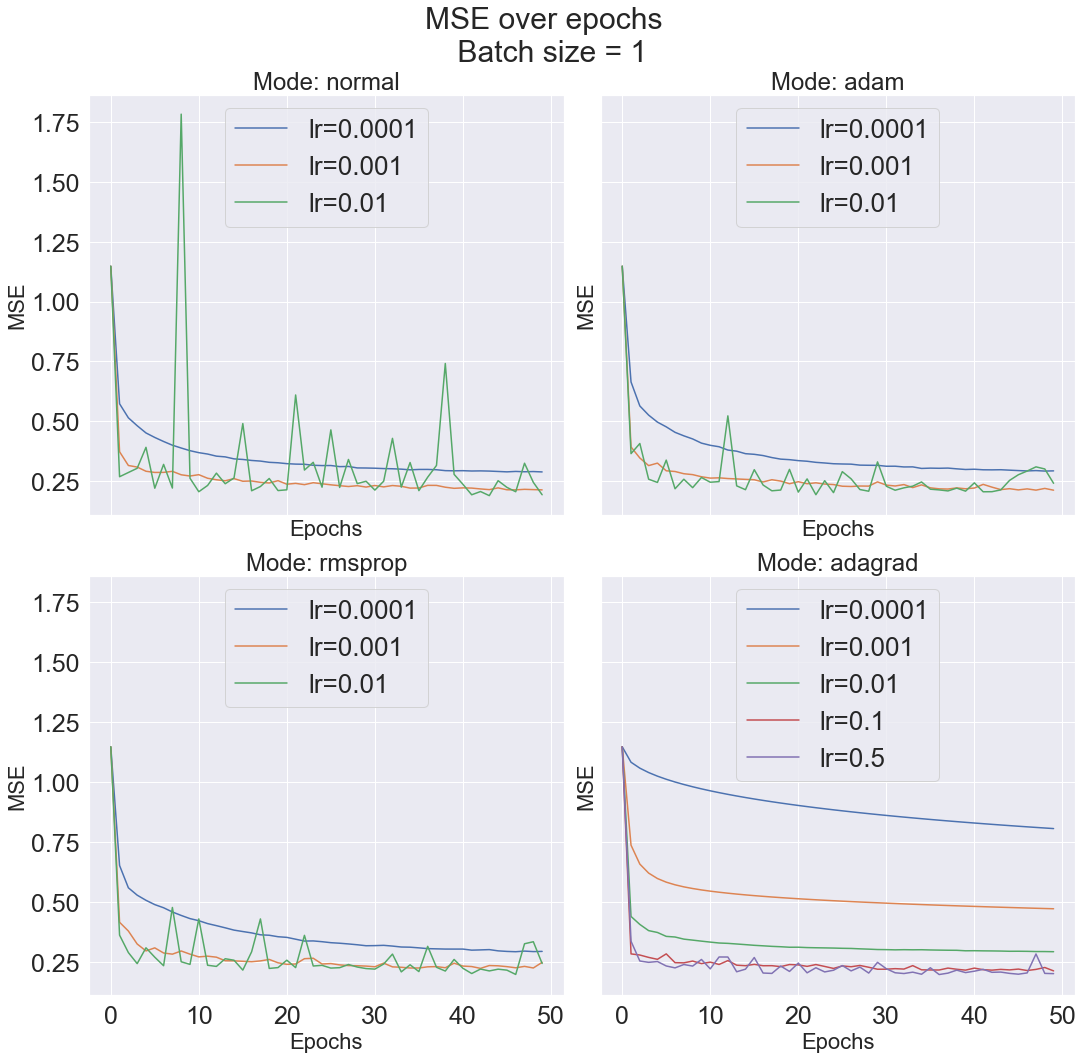

In [673]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle(f"MSE over epochs \n Batch size = 1", fontsize=30)

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=22)
    ax.set_ylabel("MSE", fontsize=22)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    ax.tick_params(labelsize=25)
    for j, lr in enumerate(learning_rates[i]):
        ax.plot(epochs_linspace[:50], MSE_modes[i][j][:50], label=f"lr={lr}")
    ax.legend(loc="upper center",fontsize=26)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/SGD_epochs_range_50")

* Four plots (for each mode) MSE over learning rate for 64, 128 and 256    

In [555]:
batch_sizes = [8, 64, 128]
epochs_stop = 1000
n_bs = len(batch_sizes)
n_lr = [20, 20, 20, 20]
lr_range_normal = np.linspace(0.001, 0.04, n_lr[0])
lr_range_adam = np.linspace(0.001, 0.03, n_lr[1])
lr_range_rmsprop = np.linspace(0.0001, 0.009, n_lr[2])
lr_range_adagrad = np.linspace(0.001, 0.5, n_lr[3])
learning_rates = [lr_range_normal, lr_range_adam, lr_range_rmsprop, lr_range_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_bs, n_lr[0]))
MSE_adam = np.zeros((n_bs, n_lr[1]))
MSE_rmsprop = np.zeros((n_bs, n_lr[2]))
MSE_adagrad = np.zeros((n_bs, n_lr[3]))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, bs in enumerate(batch_sizes):
        for k, lr in enumerate(learning_rates[i]):
            MSE_mode[j][k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                     mode=modes[i],learning_rate=lr,
                                       batch_size=bs, epochs=epochs_stop)

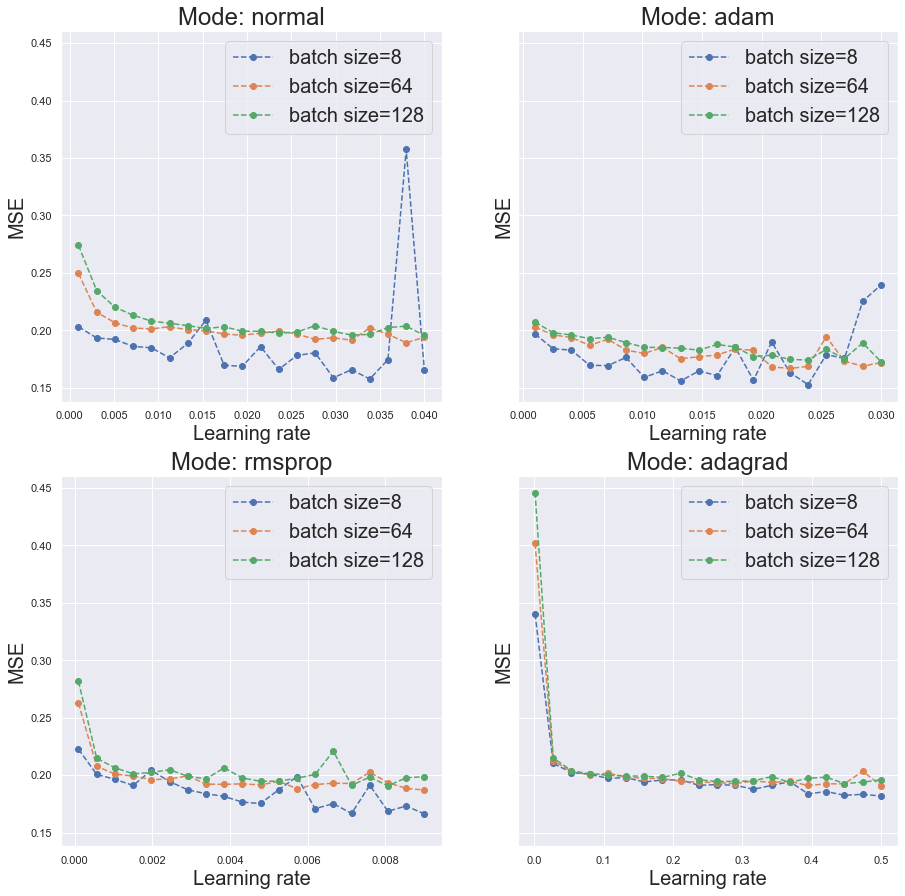

In [556]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Learning rate", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    
    for j, bs in enumerate(batch_sizes):
        ax.plot(learning_rates[i], MSE_modes[i][j][:50], "--o" ,label=f"batch size={bs}")
    ax.legend(fontsize=20)
    ax.tick_params(labelsize=25)
plt.tight_layout()
#plt.savefig("../plots/Gradient_descent/")

* MSE over epochs for batch_size 64, 128, 256 - Fixed learning rate - might differ

In [718]:
batch_sizes = [16, 64, 256]
n_bs = len(batch_sizes)
learning_rates = [0.02, 0.02, 0.02, 0.02]
epochs_stop = 1000
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)
n_epochs = len(epochs_linspace)

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_bs, n_epochs))
MSE_adam = np.zeros((n_bs, n_epochs))
MSE_rmsprop = np.zeros((n_bs, n_epochs))
MSE_adagrad = np.zeros((n_bs, n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, bs in enumerate(batch_sizes):
        MSE_mode[j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                mode=modes[i],learning_rate=learning_rates[i],
                                batch_size=bs, epochs=epochs_stop,
                               store_extra=True)

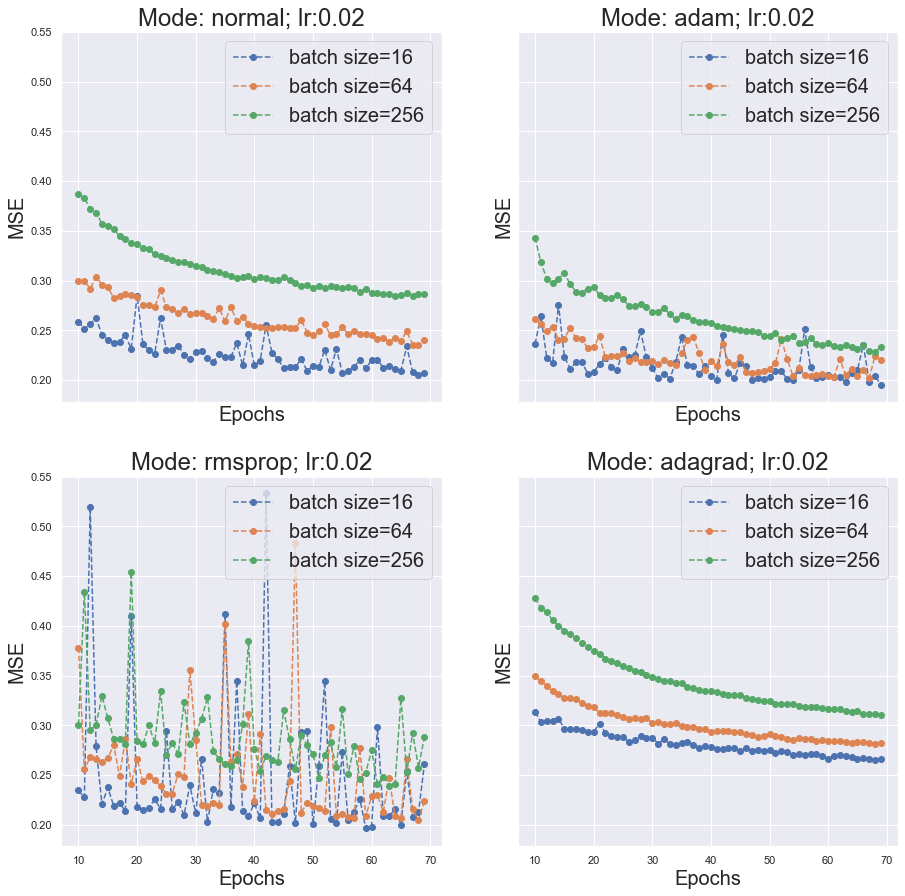

In [719]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}; lr:{learning_rates[i]}", fontsize=24)
    for j, bs in enumerate(batch_sizes):
        ax.plot(epochs_linspace[10:70], MSE_modes[i][j][10:70], "--o" ,label=f"batch size={bs}")
    ax.legend(fontsize=20)

* A set learning-rates, equal for all = 0.004

In [450]:
batch_sizes = [64, 128, 256]
n_bs = len(batch_sizes)
learning_rates = [0.004, 0.004, 0.004, 0.004]
epochs_stop = 1000
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)
n_epochs = len(epochs_linspace)

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_bs, n_epochs))
MSE_adam = np.zeros((n_bs, n_epochs))
MSE_rmsprop = np.zeros((n_bs, n_epochs))
MSE_adagrad = np.zeros((n_bs, n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, bs in enumerate(batch_sizes):
        MSE_mode[j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                mode=modes[i],learning_rate=learning_rates[i],
                                batch_size=bs, epochs=epochs_stop,
                               store_extra=True)

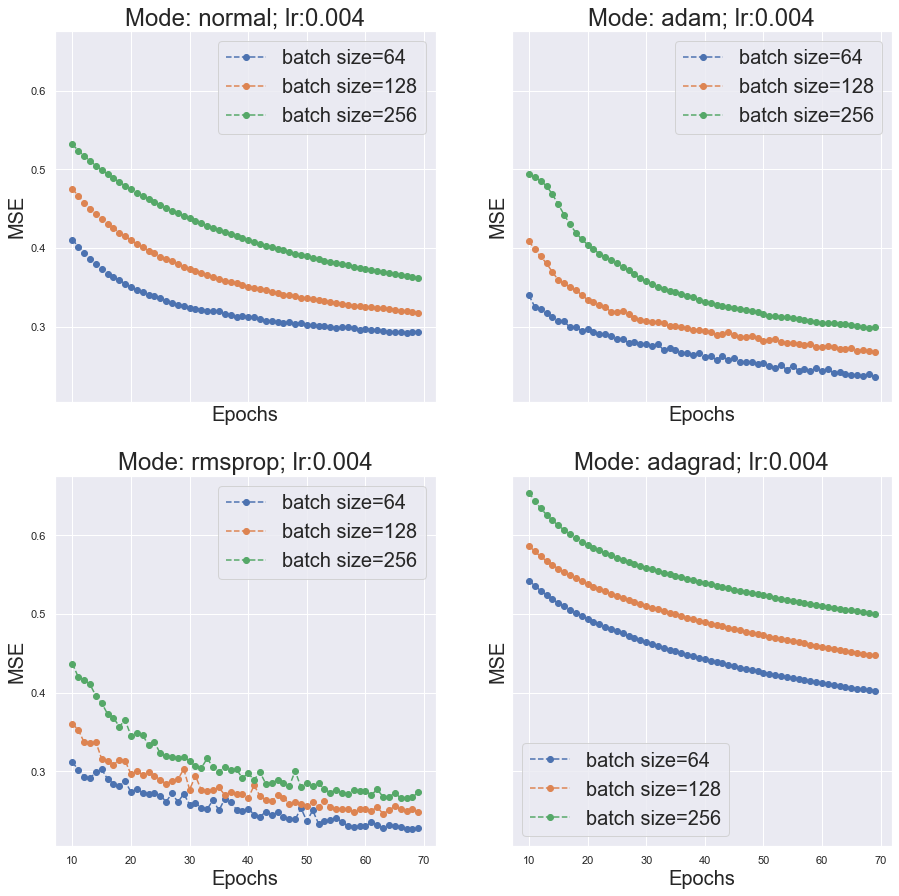

In [451]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}; lr:{learning_rates[i]}", fontsize=24)
    for j, bs in enumerate(batch_sizes):
        ax.plot(epochs_linspace[10:70], MSE_modes[i][j][10:70], "--o" ,label=f"batch size={bs}")
    ax.legend(fontsize=20)

# 3. Momentum analysis:

* MSE over momentum 4 plots (Equal Axis) for a few different learning rates   

kmt: batch size = 256 to avoid randomness from batchsizes

In [679]:
epochs_stop = 1000
batch_size = 256

n_mom = 10
momentum_range = np.linspace(0, 0.99, n_mom)
lr_normal = [0.00001, 0.0001, 0.001, 0.01, 0.04]
lr_adam = [0.00001, 0.0001, 0.0005, 0.0007]
lr_rmsprop = [0.00001, 0.0001, 0.001, 0.01, 0.04] 
lr_adagrad = [0.00001, 0.0001, 0.001, 0.01, 0.04]
learning_rates = [lr_normal, lr_adam, lr_rmsprop, lr_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((len(learning_rates[0]), n_mom))
MSE_adam = np.zeros((len(learning_rates[1]), n_mom))
MSE_rmsprop = np.zeros((len(learning_rates[2]), n_mom))
MSE_adagrad = np.zeros((len(learning_rates[3]), n_mom))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, lr in enumerate(learning_rates[i]):
        for k, mom in enumerate(momentum_range):
            MSE_mode[j][k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                    mode=modes[i],learning_rate=lr, momentum=mom,
                                    batch_size=batch_size, epochs=epochs_stop)

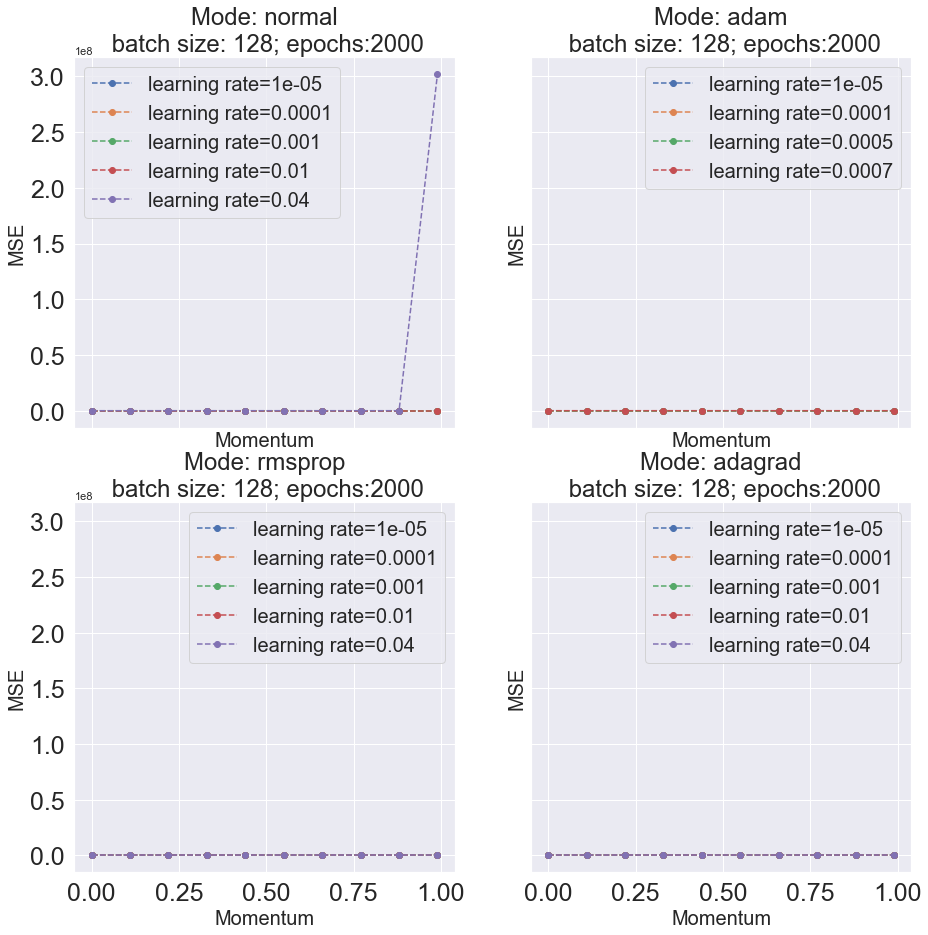

In [680]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Momentum", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}\n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    ax.tick_params(labelsize=25)
    for j, lr in enumerate(learning_rates[i]):
        ax.plot(momentum_range, MSE_modes[i][j], "--o" ,label=f"learning rate={lr}")
    ax.legend(fontsize=20)

Legger til forskjellige momentum ranges for de ulike modene. 

In [757]:
n_mom = 15
epochs_stop = 1000
batch_size = 256

momentum_range_normal = np.linspace(0, 0.9, n_mom)
momentum_range_adam = np.linspace(0, 0.9, n_mom)
momentum_range_rmsprop = np.linspace(0, 0.9, n_mom)
momentum_range_adagrad = np.linspace(0, 0.9, n_mom)

momentum_ranges = [momentum_range_normal, momentum_range_adam,
                  momentum_range_rmsprop, momentum_range_adagrad]

lr_normal = [0.001, 0.01, 0.05]
lr_adam = [0.001, 0.01, 0.05]
lr_rmsprop = [0.001, 0.01, 0.05] 
lr_adagrad = [0.001, 0.01, 0.05]
learning_rates = [lr_normal, lr_adam, lr_rmsprop, lr_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((len(learning_rates[0]), n_mom))
MSE_adam = np.zeros((len(learning_rates[1]), n_mom))
MSE_rmsprop = np.zeros((len(learning_rates[2]), n_mom))
MSE_adagrad = np.zeros((len(learning_rates[3]), n_mom))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, lr in enumerate(learning_rates[i]):
        for k, mom in enumerate(momentum_ranges[i]):
            MSE_mode[j][k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                    mode=modes[i],learning_rate=lr, momentum=mom,
                                    batch_size=batch_size, epochs=epochs_stop)
            if MSE_mode[j][k] > 1:
                MSE_mode[j][k] = np.NaN

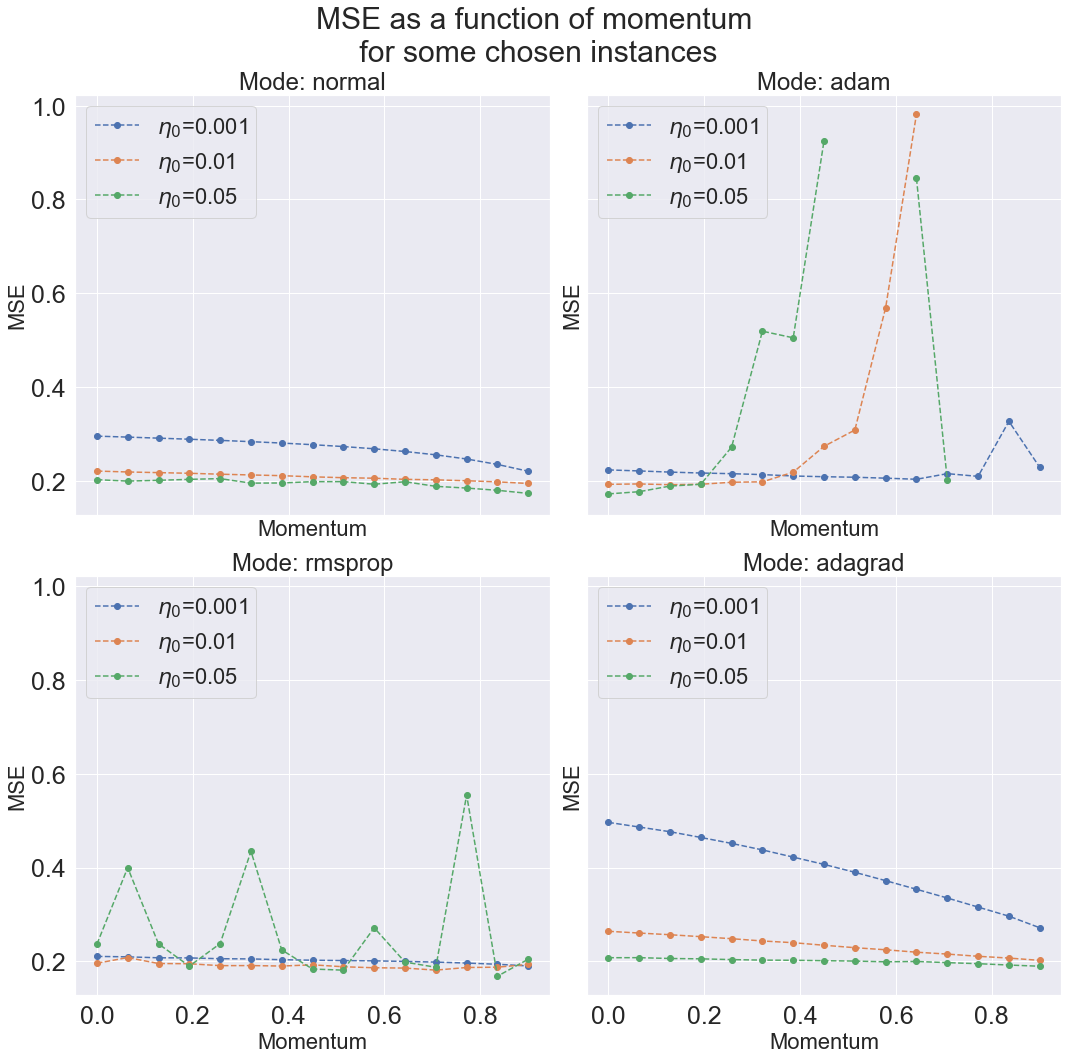

In [758]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Momentum", fontsize=22)
    ax.set_ylabel("MSE", fontsize=22)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    for j, lr in enumerate(learning_rates[i]):
        ax.plot(momentum_ranges[i], MSE_modes[i][j], "--o" ,label=f"$\eta_0$={lr}")
    ax.legend(fontsize=22, loc="upper left")
    ax.tick_params(labelsize=25)
plt.suptitle("MSE as a function of momentum\n for some chosen instances", fontsize=30)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/MSE_over_momentum")
plt.show()

## Kommenter ..

* MSE over Epochs 4 plots (Equal Axis) for a few different momentum set learing rates 

In [585]:
epochs_stop = 2000
n_epochs = epochs_stop +1
batch_size = 256
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)

lr_normal = 0.01;lr_adam= 0.001; lr_rmsprop=0.01; lr_adagrad=0.06 
learning_rates = [lr_normal, lr_adam, lr_rmsprop, lr_adagrad]

mom_normal = [0.6, 0.7 ,0.9]
mom_adam = [0, 0.02, 0.04, 0.2, 0.7]
mom_rmsprop = [0.6, 0.7, 0.9]
mom_adagrad = [0.6, 0.7, 0.9, 0.99]
momentum_modes = [mom_normal, mom_adam, mom_rmsprop, mom_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_mom, n_epochs))
MSE_adam = np.zeros((n_mom, n_epochs))
MSE_rmsprop = np.zeros((n_mom, n_epochs))
MSE_adagrad = np.zeros((n_mom, n_epochs)) 
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for i, MSE_mode in enumerate(MSE_modes):
    lr = learning_rates[i]
    for k, mom in enumerate(momentum_modes[i]):
        MSE_mode[k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                    mode=modes[i],learning_rate=lr, momentum=mom,
                                    batch_size=batch_size, epochs=epochs_stop,
                              store_extra=True)

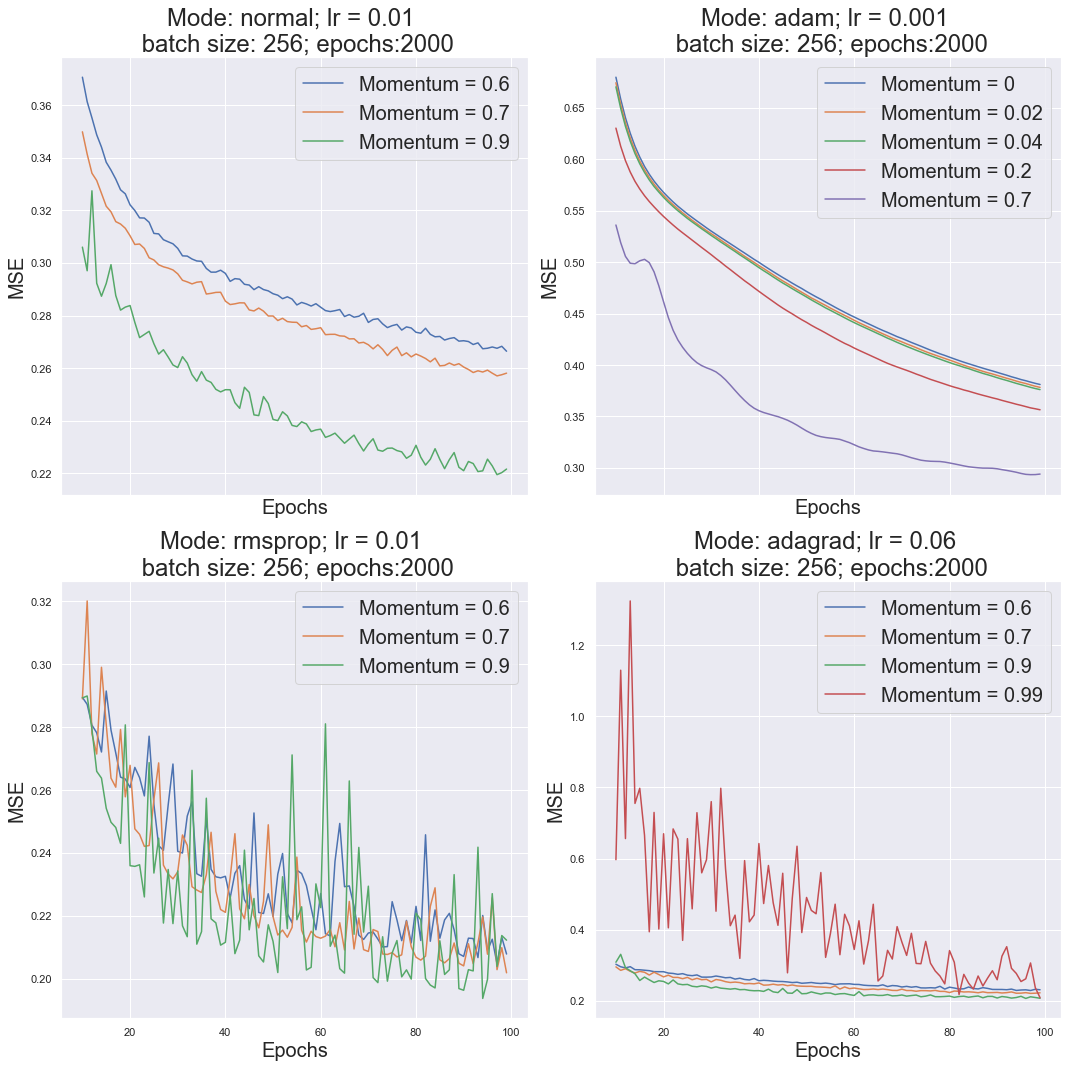

In [588]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}; lr = {learning_rates[i]} \n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    for j, mom in enumerate(momentum_modes[i]):
        ax.plot(epochs_linspace[10:100], MSE_modes[i][j][10:100] ,label=f"Momentum = {mom}")
    ax.legend(fontsize=20)
plt.tight_layout()

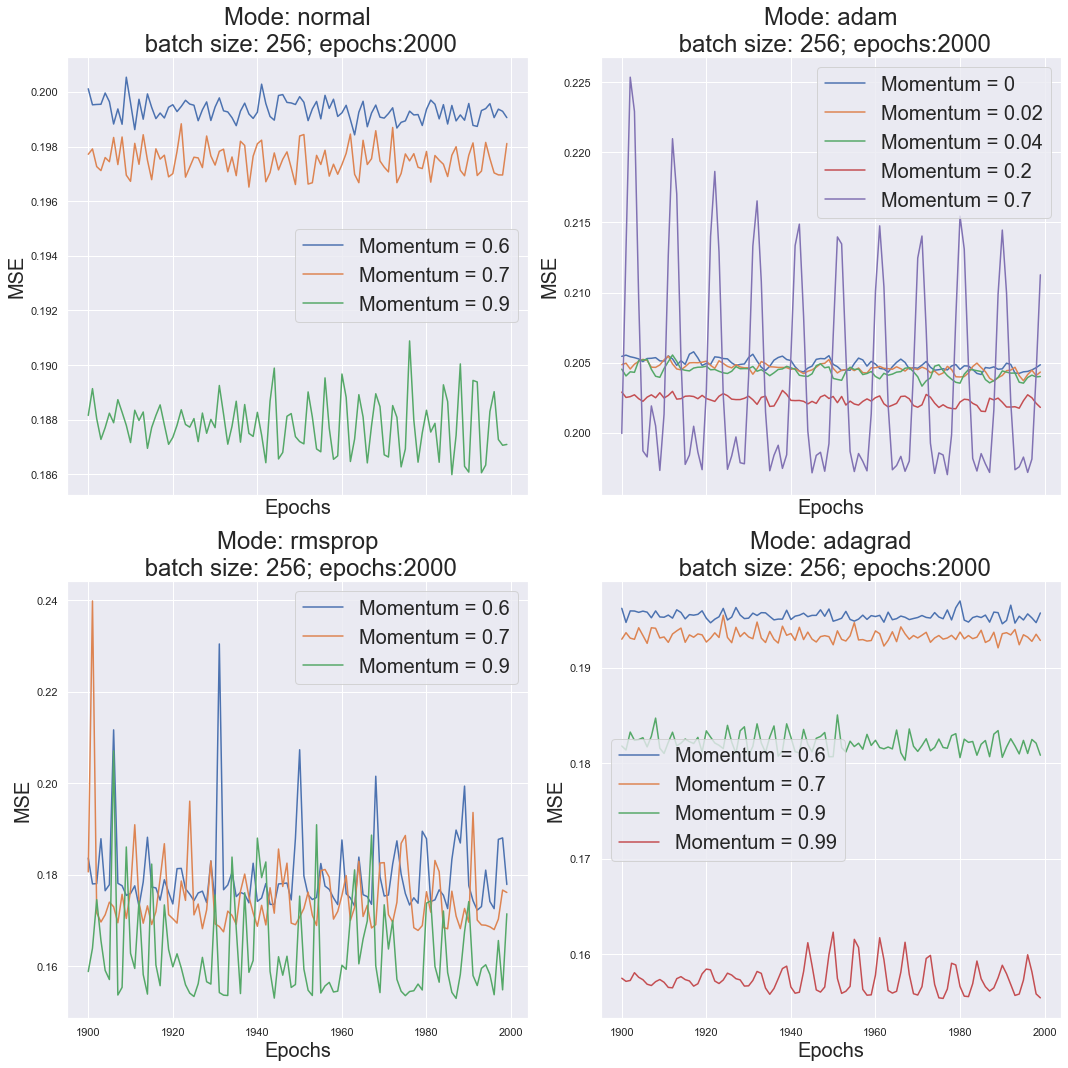

In [587]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}\n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    for j, mom in enumerate(momentum_modes[i]):
        ax.plot(epochs_linspace[1900:2000], MSE_modes[i][j][1900:2000] ,label=f"Momentum = {mom}")
    ax.legend(fontsize=20)
plt.tight_layout()

# 4. Grid searches: (random/limited area)
    
* Four plots, grid search over lambda and learningrate

    * we do this for each mode

We want to find optimal l2 regulariserings parameter aswell as optimal learning-rate. Do to constraint in computing-power we have to choose a subset of combinations to test for.
We do this by estimating a range for each paramterer based on the analysis above

In [115]:
def grid_search(X, z, lambda_range, lr_range, momentum=0.9, mode="normal", store_extra = False):
    
    X_train, X_test, X_validation = X
    z_train, z_test, z_validation = z
    
    #set mini-bach size
    batch_size = 256
    #set nr of epochs
    epochs = 2000
    
    m = momentum
    
    optimal = [None, None]
    optimal_MSE = 1000
    MSE_grid = np.zeros((len(lr_range), len(lambda_range)))
    w_log = 0
    
    progress = 0
    
    for num1, i in enumerate(lambda_range):
        model = rcf.RidgeCost(i)
        progress += 100/len(lambda_range)
        for num2, j in enumerate(lr_range):
            #init weights
            w_init = np.zeros(len(X_train[0]))
            #Make model with i and j param
            descent = gd.GradientDescent(mode=mode, momentum_param=m, batch_size=batch_size, store_extra=store_extra)
            w = descent.train(X_train, w_init, z_train, model, learning_rate=j, n_epochs = epochs)
            #calculate MSE 
            mse = rt.MSE(z_test, X_test@w.flatten())
            if mse<optimal_MSE:
                optimal_MSE = mse
                optimal = [i, j]
                if store_extra:   
                    w_log = descent.weights
            MSE_grid[num2, num1] = mse
        print(f"progress = {progress:.2f}%", end="\r")
    
    if store_extra:
        return optimal, optimal_MSE, MSE_grid, w_log
    else:
        return optimal, optimal_MSE, MSE_grid

In [116]:
lambda_range = np.logspace(-6, 0, 7)
lr_range = np.logspace(-6, -2, 5)

In [117]:
import seaborn as sns
sns.set()
modes = ["normal", "adam", "rmsprop", "adagrad"]
X = (X_train, X_test, 0)
z = (z_train, z_test, 0)

g, q, MSE_grid_normal = grid_search(X, z, lambda_range, lr_range, mode="normal")
g, q, MSE_grid_adam = grid_search(X, z, lambda_range, lr_range, mode="adam")
g, q, MSE_grid_rmsprop = grid_search(X, z, lambda_range, lr_range, mode="rmsprop")
g, q, MSE_grid_adagrad = grid_search(X, z, lambda_range, lr_range, mode="adagrad")
MSE_grid_modes = [MSE_grid_normal, MSE_grid_adam, MSE_grid_rmsprop, MSE_grid_adagrad]

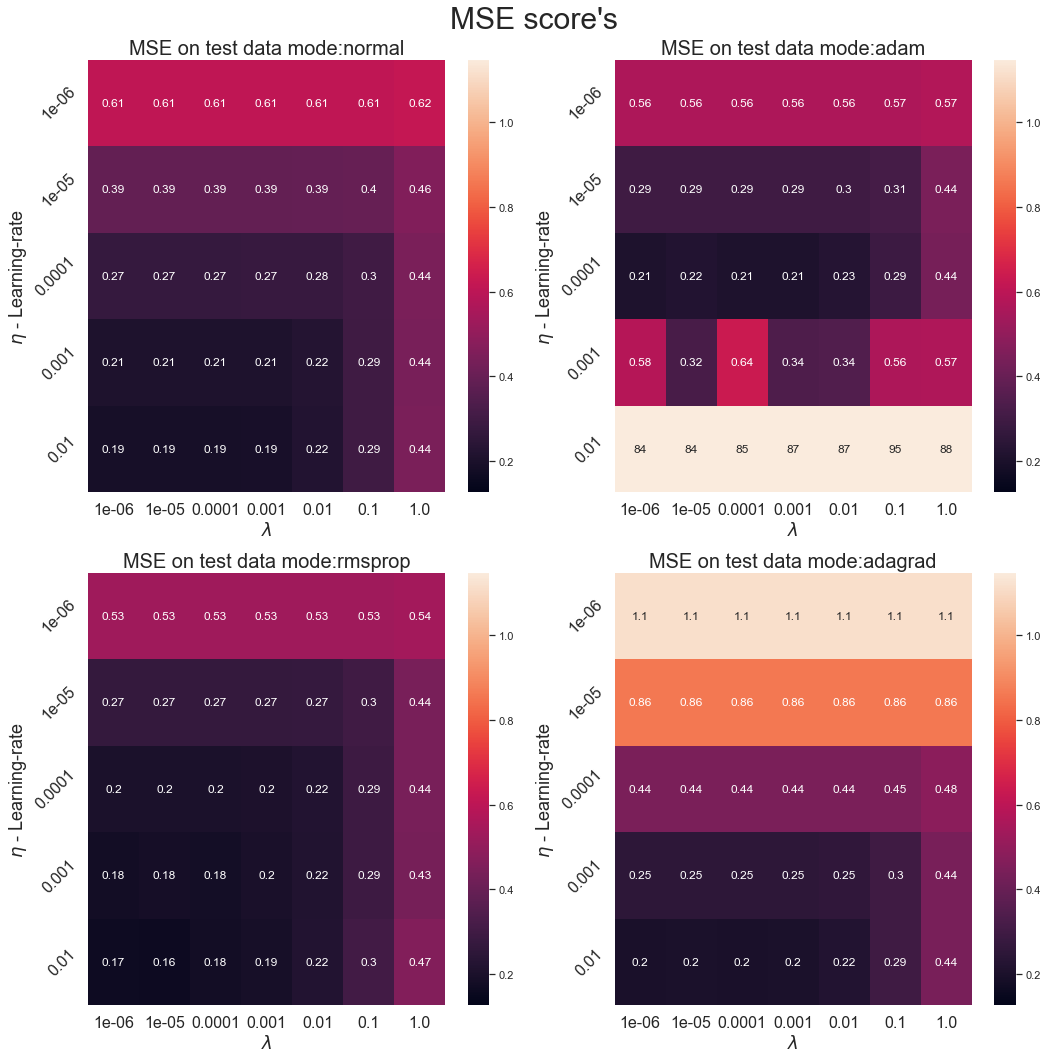

In [118]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (15, 15))
vmin = MSE_analytical_ols
vmax = rt.MSE(z_test, X_test@w_init)
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(MSE_grid_modes[i], annot=True, ax=ax, vmin=vmin , vmax=vmax)
    ax.set_title(f"MSE on test data mode:{modes[i]}", fontsize=20)
    ax.set_yticklabels(lr_range, rotation=45)
    ax.set_xticklabels(lambda_range)
    ax.set_ylabel("$\eta$ - Learning-rate", fontsize=18)
    ax.set_xlabel("$\lambda$", fontsize=18)
    ax.tick_params(labelsize=16)
plt.suptitle("MSE score's", fontsize=30)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/HM_plot_lr_lambda")
plt.show()

In [119]:
def grid_search_mom(X, z, lr_range, mom_range, mode="normal"):
    
    X_train, X_test, X_validation = X
    z_train, z_test, z_validation = z
    
    #set mini-bach size
    #set nr of epochs
    batch_size = 128
    epochs = 2000
    model = rcf.OLSCost()
    
    MSE_grid = np.zeros((len(lr_range), len(mom_range)))
    w_log = 0
    
    progress = 0
    for i, m in enumerate(mom_range):
        progress += 100/len(mom_range)
        for j, lr in enumerate(lr_range):
            #init weights
            w_init = np.zeros(len(X_train[0]))
            #Make model with i and j param
            descent = gd.GradientDescent(mode=mode, momentum_param=m,
                                         batch_size=batch_size)
            w = descent.train(X_train, w_init, z_train, model,
                              learning_rate=lr, n_epochs = epochs)
            #calculate MSE 
            mse = rt.MSE(z_test, X_test@w.flatten())
            MSE_grid[j, i] = mse
        print(f"progress = {progress:.2f}%", end="\r")
        
    return MSE_grid

In [120]:
import seaborn as sns
sns.set()
modes = ["normal", "adam", "rmsprop", "adagrad"]

lr_range = np.logspace(-8, 0, 9)
mom_range = np.linspace(0.1, 0.9, 9)
MSE_grid_normal = grid_search_mom(X, z, lr_range, mom_range, mode="normal")
MSE_grid_adam = grid_search_mom(X, z, lr_range, mom_range, mode="adam")
MSE_grid_rmsprop = grid_search_mom(X, z, lr_range, mom_range, mode="rmsprop")
MSE_grid_adagrad = grid_search_mom(X, z, lr_range, mom_range, mode="adagrad")
MSE_grid_modes = [MSE_grid_normal, MSE_grid_adam, MSE_grid_rmsprop, MSE_grid_adagrad]

/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:122: RuntimeWarning: overflow encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:122: RuntimeWarning: invalid value encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y)


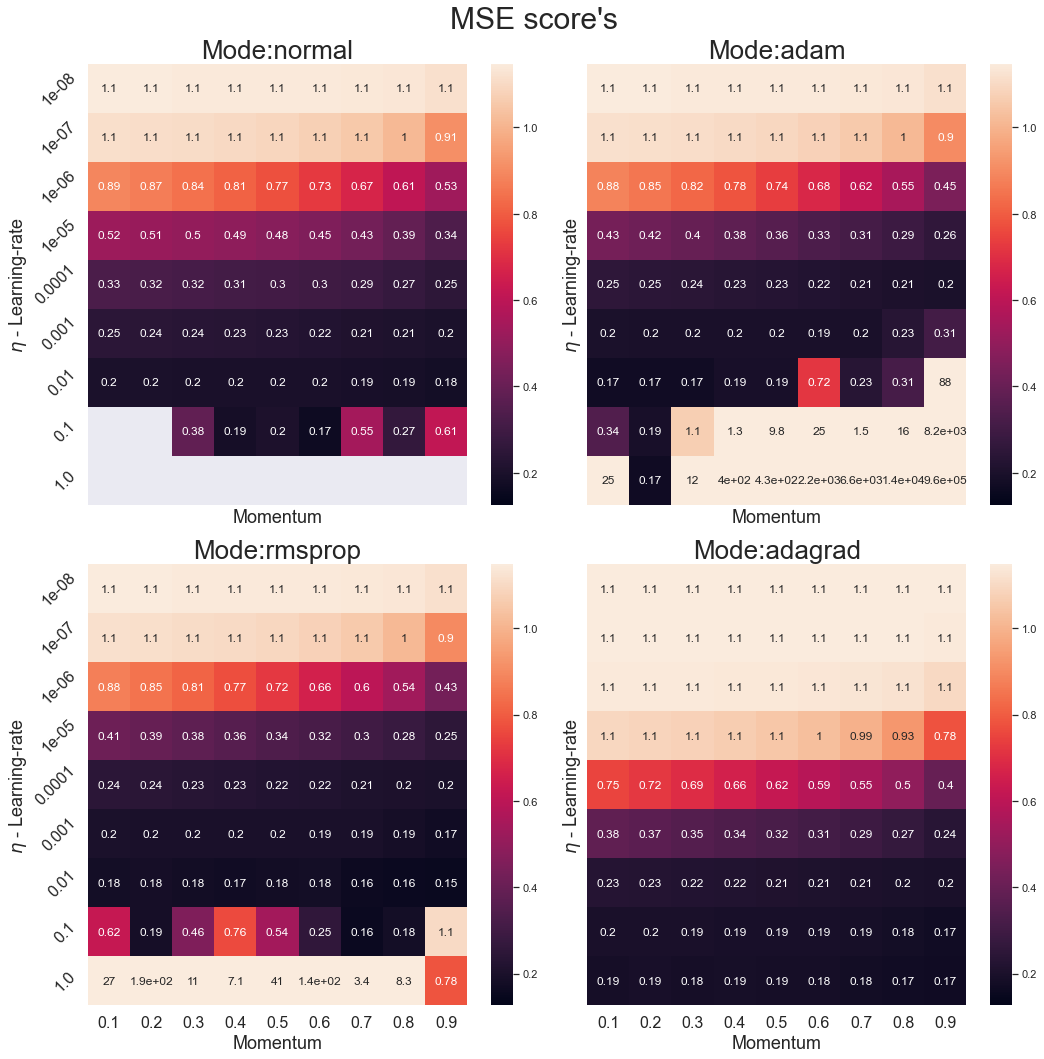

In [122]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (15, 15), sharex=True, sharey=True)
vmin = MSE_analytical_ols
vmax = rt.MSE(z_test, X_test@w_init)
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(MSE_grid_modes[i], annot=True, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(f"Mode:{modes[i]}", fontsize=26)
    ax.set_yticklabels(lr_range, rotation=45)
    ax.set_xticklabels(mom_range.round(2))
    ax.set_ylabel("$\eta$ - Learning-rate", fontsize=18)
    ax.set_xlabel("Momentum", fontsize=18)
    ax.tick_params(labelsize=16)
plt.suptitle("MSE score's", fontsize=30)
plt.tight_layout()
plt.savefig("../plots/Gradient_descent/Mom_heatmap_over_mode")
plt.show()